In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

^C
^C


In [2]:
#!git clone https://github.com/jaredleekatzman/DeepSurv.git
#!pip install "/content/gdrive/My Drive/Colab Notebooks/DeepSurv/"
#import os
#os.chdir("C:/max/Google Drive Max/Colab Notebooks/DeepSurv/deepsurv")
!pip install "/Google Drive Max/Colab Notebooks/DeepSurv")
#!pip install "deepsurv"

/bin/bash: -c: line 0: syntax error near unexpected token `)'
/bin/bash: -c: line 0: `pip install "/Google Drive Max/Colab Notebooks/DeepSurv")'


FileNotFoundError: ignored

In [0]:
# Use DeepSurv from the repo
import sys
import os
os.chdir("C:/max/Google Drive Max/Colab Notebooks/DeepSurv/deepsurv")
          
import deepsurv

from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


# Read in dataset
First, I read in the dataset and print the first five elements to get a sense of what the dataset looks like

In [3]:
os.chdir("C:/max/Google Drive Max/Colab Notebooks/Survival")
train_dataset_fp = 'example_data.csv'
train_df = pd.read_csv(train_dataset_fp)
train_df.head()

,Variable_1,Variable_2,Variable_3,Variable_4,Event,Time
0,0,3,2,4.6,1,43
1,0,2,0,1.6,0,52
2,0,3,0,3.5,1,73
3,0,3,1,5.1,0,51
4,0,2,0,1.7,0,51


# Transform the dataset to "DeepSurv" format
DeepSurv expects a dataset to be in the form:

    {
        'x': numpy array of float32
        'e': numpy array of int32
        't': numpy array of float32
        'hr': (optional) numpy array of float32
    }
    
You are providing me a csv, which I read in as a pandas dataframe. Then I convert the pandas dataframe into the DeepSurv dataset format above. 

In [0]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')

In [5]:
train_data

{'x': array([[0. , 3. , 2. , 4.6],
        [0. , 2. , 0. , 1.6],
        [0. , 3. , 0. , 3.5],
        ...,
        [0. , 3. , 0. , 3.1],
        [0. , 2. , 0. , 1.8],
        [0. , 2. , 0. , 2.3]], dtype=float32),
 'e': array([1, 0, 1, ..., 0, 0, 1]),
 't': array([43., 52., 73., ...,  4., 41., 33.], dtype=float32)}

Now once you have your dataset all formatted, define you hyper_parameters as a Python dictionary. 
I'll provide you with some example hyper-parameters, but you should replace the values once you tune them to your specific dataset

In [0]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [25, 25],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

Once you prepared your dataset, and defined your hyper-parameters. Now it's time to train DeepSurv!

In [7]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deepsurv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_sebastian'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn)

2019-10-24 19:47:06,675 - Training step 0/2000    |                         | - loss: 24.9896 - ci: 0.3906
2019-10-24 19:47:39,812 - Training step 250/2000  |***                      | - loss: 12.6521 - ci: 0.4383
2019-10-24 19:48:15,370 - Training step 500/2000  |******                   | - loss: 8.3938 - ci: 0.4923
2019-10-24 19:48:49,194 - Training step 750/2000  |*********                | - loss: 6.9273 - ci: 0.5588
2019-10-24 19:49:24,031 - Training step 1000/2000 |************             | - loss: 6.4372 - ci: 0.6220
2019-10-24 19:49:58,388 - Training step 1250/2000 |***************          | - loss: 6.2531 - ci: 0.6903
2019-10-24 19:50:35,417 - Training step 1500/2000 |******************       | - loss: 6.1985 - ci: 0.7052
2019-10-24 19:51:12,089 - Training step 1750/2000 |*********************    | - loss: 6.1759 - ci: 0.7104
2019-10-24 19:51:47,049 - Finished Training with 2000 iterations in 281.44s


# New Section

There are two different ways to visualzie how the model trained:

- Tensorboard (install ()[tensorboard]) which provides realtime metrics. Run the command in shell:
   
   `tensorboard --logdir './logs/tensorboard'`
     
     
- Visualize the training functions post training (below)

Train C-Index: (1999, 0.7120210909642668)


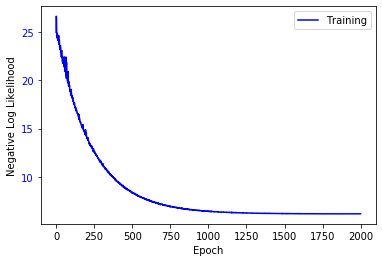

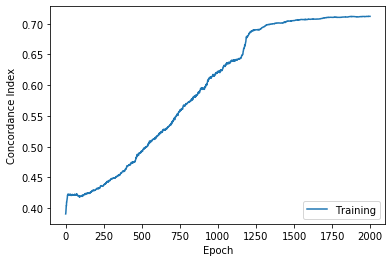

In [8]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)